In [1]:
import geopandas
import matplotlib.pyplot as plt
import requests
from cartogrampy.cartogram import Cartogram
import json
import pandas as pd

/home/max/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_84408/234360596.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.htm

In [2]:
df = geopandas.read_file('RBS_OD_UWB_AH21.dbf') #  Geodata from https://daten.berlin.de/datensaetze/geometrien-der-wahlbezirke-f%C3%BCr-die-wahlen-zum-deutschen-bundestag-berlin-und-zum
df["weight"] = 1

In [6]:
result_url = "https://www.tagesschau.de/wahl/archiv/2023-02-12-LT-DE-BE/karte/data-G.json?4c2b02a5-7eba-456e-a648-fe84e5ca1523"
res = requests.get(result_url)
data = json.loads(res.content)

results = data["results"]
pcolours = data["partycolors"]
parties = data["parties"]

result_list = []
for a, b in results["Gemeinden"].items():
    r = dict(zip(parties,b[3])) # Get the Erststimmen for each party
    r["BWB"] = a[1:]
    result_list.append(r)
result_df = pd.DataFrame(result_list)
result_df = result_df.drop(columns="BET")
parties = [x for x in parties if x!="BET"]
result_df["max"] = result_df[parties].apply(max,axis=1) # Get the maximum result in each district
for p in parties:
    print(p)
    winning_indices = result_df[p]==result_df["max"] # the districts where the party won largest share
    print(winning_indices.sum())
    result_df.loc[winning_indices,"winner"] = p
    result_df.loc[winning_indices,"colour"] = pcolours[p]
result_df

df = df.merge(result_df) # merge with the geographic data

SPD
73
GRÜNE
433
CDU
885
LINKE
90
AFD
29
FDP
0


(369942.7468536391, 415539.00955103757, 5799052.90832902, 5837092.479532665)

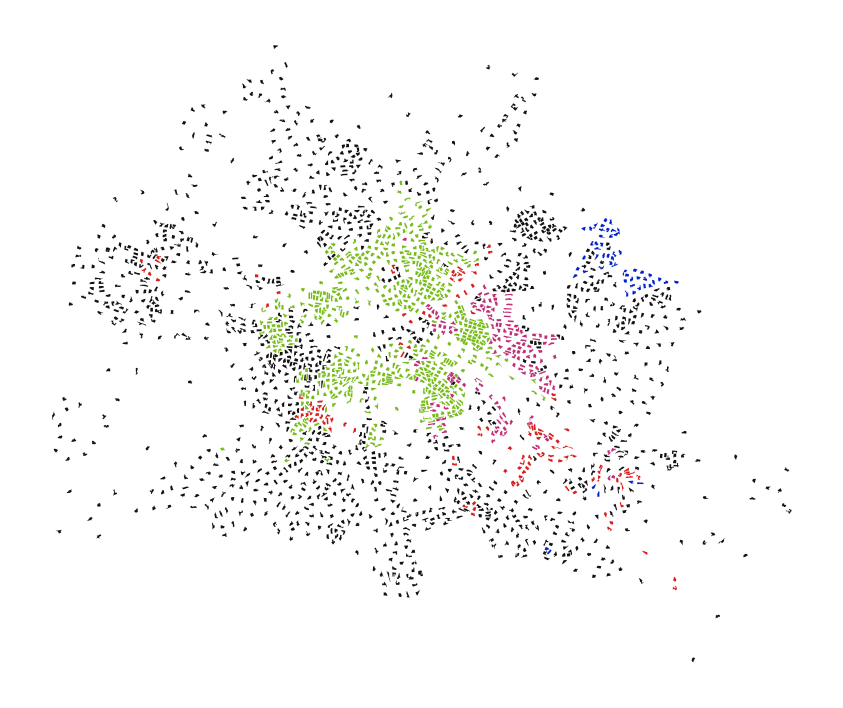

In [4]:
cgm = Cartogram(df,"weight")
noncont = cgm.noncont()

fig, ax = plt.subplots(figsize=(7,7), dpi=150)
noncont.plot(ax=ax, color=df["colour"])
ax.axis("off")